In [1]:
#importing modules
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization,Dropout
import numpy as np
from tensorflow.keras.regularizers import L2

In [2]:
#loading dataset 
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    image_size=(256,256),
    batch_size=32
)

Found 3002 files belonging to 2 classes.


In [3]:
class_names=dataset.class_names
class_names

['Cancer', 'Non Cancer']

In [4]:
#finding how many total batches of images are there
len(dataset)

94

2025-12-01 18:55:33.255274: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


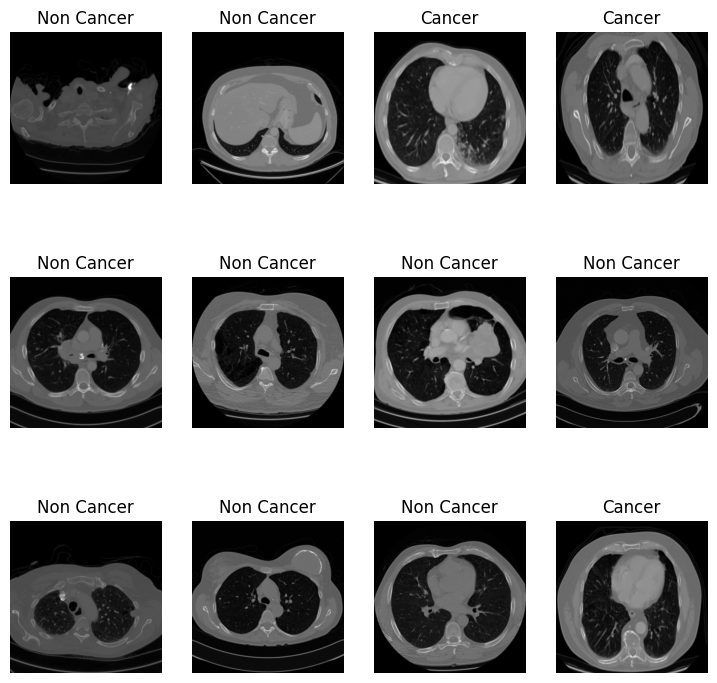

In [5]:
#Vizualizing the dataset 
plt.figure(figsize=(9,9))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
      ax=plt.subplot(3,4,i+1)  
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])  
      plt.axis("off")   
    
    

In [6]:
#A function to split the dataset into training,validation and testing
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
#Splitting the dataset into training, validation and testing
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
len(train_ds),len(val_ds),len(test_ds)

(75, 9, 10)

In [9]:
#Shuffling and PreFetching the dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
#Resizing and Rescaling the Images
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255),
])

In [11]:
#Performing Data Augumentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.5),
])

In [26]:
from keras import backend as K
K.clear_session()

In [27]:
#Bulding the Neural Network
input_shape=(32,256,256,3)
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    BatchNormalization(),
    layers.Dense(2,activation="softmax"),
])
model.build(input_shape=input_shape)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 64)               │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 2)                │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,938 (718.51 KB)

 Trainable params: 183,810 (718.01 KB)

 Non-trainable params: 128 (512.00 B)

In [29]:
#Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
#Training the model
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
    
)

Epoch 1/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 367ms/step - accuracy: 0.7960 - loss: 0.4679 - val_accuracy: 0.8403 - val_loss: 0.5231
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 378ms/step - accuracy: 0.8987 - loss: 0.2729 - val_accuracy: 0.5104 - val_loss: 0.6215
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 394ms/step - accuracy: 0.8996 - loss: 0.2667 - val_accuracy: 0.7153 - val_loss: 0.4991
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 396ms/step - accuracy: 0.9138 - loss: 0.2367 - val_accuracy: 0.9201 - val_loss: 0.2863
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 397ms/step - accuracy: 0.9166 - loss: 0.2270 - val_accuracy: 0.9410 - val_loss: 0.1996
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 401ms/step - accuracy: 0.9280 - loss: 0.1850 - val_accuracy: 0.8264 - val_loss: 0.4559
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 404ms/step - accuracy: 0.9233 - loss: 0.1853 - val_accuracy: 0.7604 - val_loss: 0.4485
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 916ms/step - accuracy: 0.9352 - loss: 0.1617 - val_accu

In [31]:
model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9860 - loss: 0.0401


[0.06557875126600266, 0.9750000238418579]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

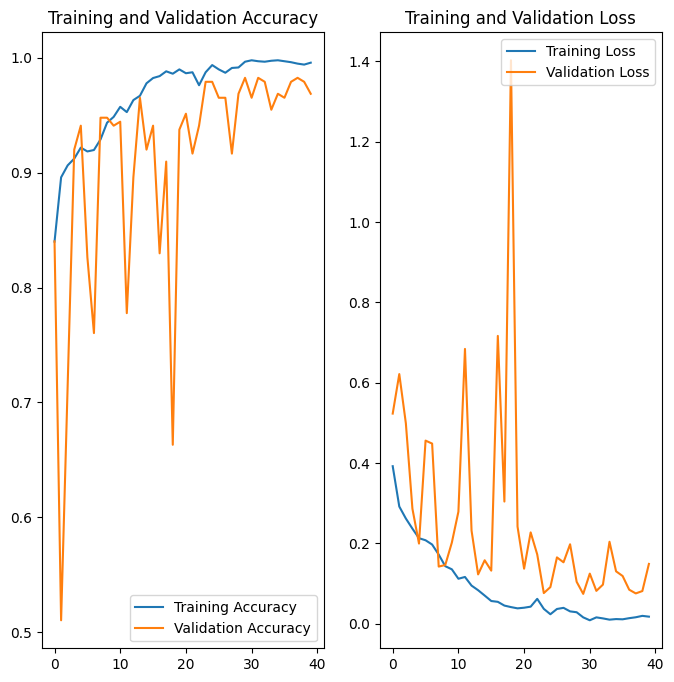

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(40), acc, label='Training Accuracy')
plt.plot(range(40), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(40), loss, label='Training Loss')
plt.plot(range(40), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2025-12-01 20:59:00.237439: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


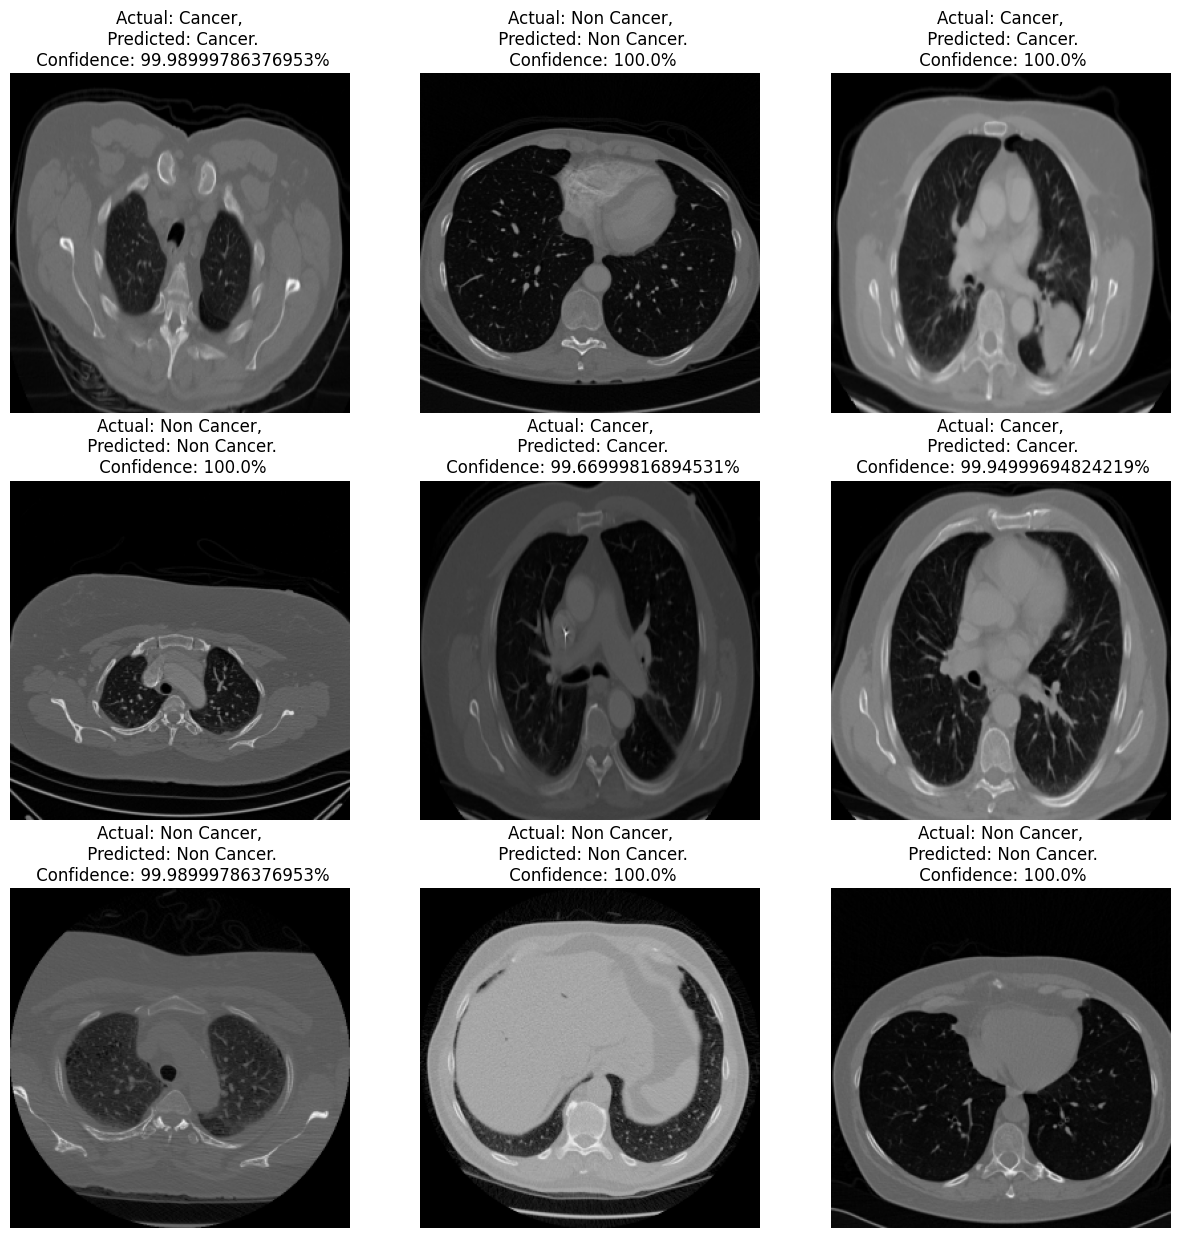

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

X_test shape: (320, 256, 256, 3)
y_true shape: (320,)
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


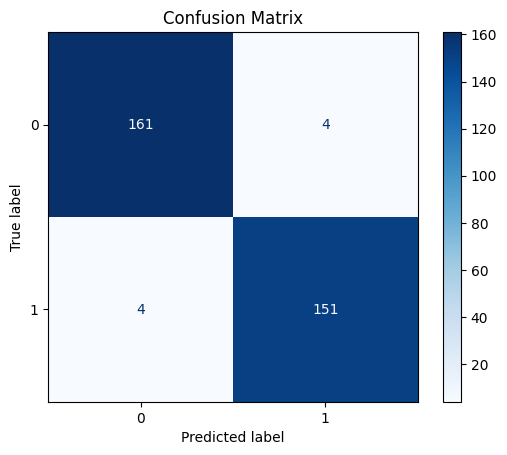


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       165
           1       0.97      0.97      0.97       155

    accuracy                           0.97       320
   macro avg       0.97      0.97      0.97       320
weighted avg       0.97      0.97      0.97       320



In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ------------------------------
# 1️⃣ Convert test_ds → NumPy arrays
# ------------------------------
X_test = []
y_true = []

for images, labels in test_ds:
    X_test.append(images)
    y_true.append(labels)

X_test = np.concatenate(X_test)
y_true = np.concatenate(y_true)

print("X_test shape:", X_test.shape)
print("y_true shape:", y_true.shape)

# ------------------------------
# 2️⃣ Predict using your trained model
# ------------------------------
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# ------------------------------
# 3️⃣ Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ------------------------------
# 4️⃣ Classification Report
# ------------------------------
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))
